In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import norm
from scipy.optimize import brentq

# surpress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
backtesting_df = pd.read_excel('./data/backtesting.xlsx')
dax = pd.read_excel('./data/dax.xlsx')

In [3]:
def put_side(df, dax):
    cash = 25000
    cash_history = []
    open_positions = []
    transaction_history = []
    put_distance_history = []
    transaction_cost = 1
    long_put_range = [3,6]
    short_put_range = [20,30]
    expiry_days = backtesting_df.strike_date.unique()
    trading_days = expiry_days + pd.DateOffset(days=-1)
    missing_strikes = [pd.to_datetime('18.04.2019'),pd.to_datetime('17.07.2020'), pd.to_datetime('14.04.2022')]
    counter = 0
    short_put_range_history = []
    long_put_range_history = []

    state = {
        'short_put_range' : short_put_range,
        'long_put_range' : long_put_range,
        'open_positions' : open_positions,
        'transaction_history' : transaction_history,
        'transaction_cost' : transaction_cost,
        'cash' : cash,
        'cash_history' : cash_history,
        'put_distance_history' : put_distance_history,
        'short_put_range_history' : short_put_range_history,
        'long_put_range_history' : long_put_range_history
    }

    for day, day_df in tqdm(df.groupby('date')):
        if day in trading_days:
            if not(len(state['open_positions']) == 0):
                process_open_positions(state, day, day_df, transaction_cost)

            all_candidates = get_all_candidates(day_df, 'P')
            if all_candidates.empty:
                if counter < 3:
                    short_candidates, long_candidates = compute_missing_month_canidates(state, day, day_df, dax, missing_strikes[counter])
                    counter += 1
                else :
                    continue
            else:
                short_candidates, long_candidates = filter_candidates(state, all_candidates, dax)
            open_new_positions(state, day, short_candidates, long_candidates)
            state['short_put_range_history'].append({'day': day, 'range': state['short_put_range']})
            state['long_put_range_history'].append({'day': day, 'range': state['long_put_range']})
            state['short_put_range'] = [20,30]
        else:
            continue
    return state

def compute_missing_month_canidates(state, day, day_df, dax, strike_date):
    short_premium = sum(state['short_put_range'])/len(state['short_put_range'])
    long_premium = sum(state['long_put_range'])/len(state['long_put_range'])
    iv = day_df['price_v1xi'].iloc[0]
    rfi = dax[dax['Date'] == day]['price_rfi'].iloc[0]
    time_till_expiry = (strike_date - day).days

    theoretical_short_strike = find_strike_for_premium(day_df['dax_typical'].iloc[0], time_till_expiry, rfi, iv, short_premium)
    rounded_short_strike = round_short_strike(theoretical_short_strike)
    short_option_price = black_scholes_put(day_df['dax_typical'].iloc[0], rounded_short_strike, time_till_expiry, rfi, iv)

    theoretical_long_strike = find_strike_for_premium(day_df['dax_typical'].iloc[0], time_till_expiry, rfi, iv, long_premium)
    rounded_long_strike = round_long_strike(theoretical_long_strike)
    long_option_price = black_scholes_put(day_df['dax_typical'].iloc[0], rounded_long_strike, time_till_expiry, rfi, iv)

    short_candidate = {
        'date': day.to_datetime64(),
        'option_type': 'P',
        'strike_price': rounded_short_strike,
        'strike_date': strike_date,
        'time_till_expiry': time_till_expiry,
        'implied volatility': iv,
        'option_typical': short_option_price
    }
    long_candidate = {
        'date': day.to_datetime64(),
        'option_type': 'P',
        'strike_price': rounded_long_strike,
        'strike_date': strike_date,
        'time_till_expiry': time_till_expiry,
        'implied volatility': iv,
        'option_typical': long_option_price
    }
    short_candidates = pd.DataFrame([short_candidate])
    long_candidates = pd.DataFrame([long_candidate])
    return short_candidates, long_candidates

def open_new_positions(state, day, short_candidates, long_candidates):
    short = short_candidates.loc[short_candidates.option_typical.idxmax()]
    long = long_candidates.loc[long_candidates.option_typical.idxmin()]
    short_transaction = create_transaction(day, 'sell', short, short['option_typical'])
    long_transaction = create_transaction(day, 'buy', long, long['option_typical'])
    state['put_distance_history'].append(short['strike_price'] - long['strike_price'])
    open_new_side(state, short_transaction, long_transaction)

def open_new_side(state, short_transaction, long_transaction):
    state['open_positions'].extend([short_transaction, long_transaction])
    state['transaction_history'].extend([short_transaction, long_transaction])

    state['cash'] -= (long_transaction['premium'] * long_transaction['quantity'] * 5) + state['transaction_cost']
    state['cash'] += (short_transaction['premium'] * short_transaction['quantity'] * 5) - state['transaction_cost']
    state['cash_history'].append({'date': short_transaction['date'], 'cash': state['cash'], 'action': 'open'})

def filter_candidates(state, all_candidates, dax):
    short_candidates = all_candidates[(all_candidates['option_typical'] > state['short_put_range'][0]) &
                                      (all_candidates['option_typical'] < state['short_put_range'][1])]
    long_candidates = all_candidates[(all_candidates['option_typical'] > state['long_put_range'][0]) &
                                     (all_candidates['option_typical'] < state['long_put_range'][1])]
    if short_candidates.empty:
        short_candidates = all_candidates[(all_candidates['option_typical'] > state['short_put_range'][0])]
        if not(short_candidates.empty):
            short_candidates = short_candidates.loc[short_candidates.option_typical.idxmin()].to_frame().T
        else:
            short_candidates = get_short_option(state, dax, all_candidates)
    
    if long_candidates.empty:
        long_candidates = all_candidates[(all_candidates['option_typical'] >= state['long_put_range'][0])]
        if not(long_candidates.empty):
            long_candidates = long_candidates.loc[long_candidates.strike_price.idxmin()].to_frame().T
            if long_candidates.option_typical.iloc[0] > 500:
                long_candidates = get_long_option(state, dax, all_candidates)
        else:
            long_candidates = get_long_option(state, dax, all_candidates)
    
    return short_candidates, long_candidates

def get_short_option(state, dax, all_candidates):
    date = all_candidates['date'].iloc[0]
    underlying_price = all_candidates['dax_typical'].iloc[0]
    rfi = dax[dax['Date'] == date]['price_rfi'].iloc[0]
    iv = compute_med_iv(all_candidates)
    desired_premium = state['short_put_range'][0]
    time_till_expiry = all_candidates['time_till_expiry'].iloc[0]

    theoretical_strike = find_strike_for_premium(underlying_price, time_till_expiry, rfi, iv, desired_premium)
    rounded_strike = round_short_strike(theoretical_strike)
    option_price = black_scholes_put(underlying_price, rounded_strike, time_till_expiry, rfi, iv)

    candidate = {
        'date': date.to_datetime64(),
        'option_type': 'P',
        'strike_price': rounded_strike,
        'strike_date': all_candidates['strike_date'].iloc[0],
        'time_till_expiry': time_till_expiry,
        'implied volatility': iv,
        'option_typical': option_price
    }
    short_candidates = pd.DataFrame([candidate])
    return short_candidates
    
def get_long_option(state, dax, all_candidates):
    date = all_candidates['date'].iloc[0]
    underlying_price = all_candidates['dax_typical'].iloc[0]
    rfi = dax[dax['Date'] == date]['price_rfi'].iloc[0]
    iv = compute_med_iv(all_candidates)
    desired_premium = state['long_put_range'][0]
    time_till_expiry = all_candidates['time_till_expiry'].iloc[0]

    theoretical_strike = find_strike_for_premium(underlying_price, time_till_expiry, rfi, iv, desired_premium)
    rounded_strike = round_long_strike(theoretical_strike)
    option_price = black_scholes_put(underlying_price, rounded_strike, time_till_expiry, rfi, iv)

    candidate = {
        'date': date.to_datetime64(),
        'option_type': 'P',
        'strike_price': rounded_strike,
        'strike_date': all_candidates['strike_date'].iloc[0],
        'time_till_expiry': time_till_expiry,
        'implied volatility': iv,
        'option_typical': option_price
    }
    long_candidates = pd.DataFrame([candidate])
    return long_candidates

def compute_med_iv(all_candidates):
    return all_candidates['implied volatility'].median()

def black_scholes_put(S, K, T, r, sigma):
    """
    Compute the Black-Scholes price of a European put option.
    
    S: Current price of the underlying asset
    K: Strike price
    T: Time to expiration (in years)
    r: Risk-free interest rate (annual)
    sigma: Volatility of the underlying asset
    """
    T = T / 365
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price =  K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price


def find_strike_for_premium(S, T, r, sigma, desired_premium):
    def objective(X):
        return black_scholes_put(S, X, T, r, sigma) - desired_premium
    
    lower_bound = 0.01
    upper_bound = S * 2

    strike_price = brentq(objective, lower_bound, upper_bound, xtol=1e-6)
    return strike_price

def round_short_strike(value, multiple=50):
    return value - (value % multiple)

def round_long_strike(value, multiple=50):
    return value + (multiple - value % multiple)

def process_open_positions(state, day, day_df, transaction_cost):
    if not state['open_positions']:
        return
    
    positions_df = pd.DataFrame(state['open_positions'])
    merged_df = positions_df.merge(day_df, how='left', on=['strike_date', 'option_type', 'strike_price'])

    if merged_df.empty:
        print('need to handle missing merge')
        return

    for idx, row in merged_df.iterrows():
        if pd.isna(row['Close']):
            strike_price = row['strike_price']
            dax_typical = day_df['dax_typical'].iloc[0]
            if strike_price > dax_typical-100:
                close_price = 0
            else:
                rfi = dax[dax['Date'] == day]['price_rfi'].iloc[0]
                strike_today_df = day_df[day_df['strike_date'] == day + pd.DateOffset(days=1)]
                iv = compute_med_iv(strike_today_df)
                close_price = black_scholes_put(dax_typical, strike_price, 1/365, rfi, iv)
        else:
            close_price = row['Close']
        open_pos = positions_df.loc[idx]

        if 'buy' == open_pos['action']:
            if np.isnan(close_price):
                rfi = dax[dax['Date'] == day]['price_rfi'].iloc[0]
                strike_today_df = day_df[day_df['strike_date'] == day + pd.DateOffset(days=1)]
                iv = strike_today_df['put_vwaiv'].iloc[0]
                close_price = black_scholes_put(dax_typical, strike_price, 1/365, rfi, iv)
                if np.isnan(close_price):
                    iv = strike_today_df['price_v1xi'].iloc[0]
                    close_price = black_scholes_put(dax_typical, strike_price, 1/365, rfi, iv)
            handle_buy_position(state, day, open_pos, close_price, transaction_cost)
        elif 'sell' == open_pos['action']:
            if np.isnan(close_price):
                rfi = dax[dax['Date'] == day]['price_rfi'].iloc[0]
                strike_today_df = day_df[day_df['strike_date'] == day + pd.DateOffset(days=1)]
                iv = strike_today_df['put_vwaiv'].iloc[0]
                close_price = black_scholes_put(dax_typical, strike_price, 1/365, rfi, iv)
                if np.isnan(close_price):
                    iv = strike_today_df['price_v1xi'].iloc[0]
                    close_price = black_scholes_put(dax_typical, strike_price, 1/365, rfi, iv)
            handle_sell_position(state, day, open_pos, close_price, transaction_cost)
        else:
            raise ValueError('Invalid action')
    
def handle_buy_position(state, day, open_pos, close_price, transaction_cost):
    if close_price < 1:
        mark_position_worthless(state, day, open_pos)
    else:
        state['cash'] += (close_price * 1) * 5 - transaction_cost
        state['cash_history'].append({'date': day, 'cash': state['cash'], 'action': 'sellback'})
        transaction = create_transaction(day, 'sellback', open_pos, close_price)
        state['transaction_history'].append(transaction)
        state['open_positions'].remove(open_pos.to_dict())
        state['short_put_range'] = [x - close_price for x in state['short_put_range']]

def handle_sell_position(state, day, open_pos, close_price, transaction_cost):
    if close_price < 1:
        mark_position_worthless(state, day, open_pos)
    else:
        state['cash'] -= (close_price * 1) * 5 + transaction_cost
        state['cash_history'].append({'date': day, 'cash': state['cash'], 'action': 'buyback'})
        transaction = create_transaction(day, 'buyback', open_pos, close_price)
        state['transaction_history'].append(transaction)
        state['open_positions'].remove(open_pos.to_dict())
        state['short_put_range'] = [x + close_price for x in state['short_put_range']]

def mark_position_worthless(state, day, open_pos):
    transaction = {
        'date': day,
        'action': 'worthless',
        'option_type': open_pos['option_type'],
        'strike_price': open_pos['strike_price'],
        'strike_date': open_pos['strike_date'],
        'premium': 0,
        'quantity': 1
    }
    state['transaction_history'].append(transaction)
    state['open_positions'].remove(open_pos.to_dict())

def create_transaction(day, action, open_pos, premium):
    return {
        'date': day,
        'action': action,
        'option_type': open_pos['option_type'],
        'strike_price': open_pos['strike_price'],
        'strike_date': open_pos['strike_date'],
        'premium': premium,
        'quantity': 1
    }

def get_all_candidates(df, type='C'):
    all_candidates = df[(df['option_type'] == type) &
                        (df['time_till_expiry'] > 15) &
                        (df['time_till_expiry'] < 45)]
    return all_candidates

In [4]:
state_put = put_side(backtesting_df, dax)

100%|██████████| 1399/1399 [00:00<00:00, 6098.52it/s]


In [5]:
def compute_performance_pairs(state):
    transaction_history_df = pd.DataFrame(state['transaction_history'])
    returns = []
    limit = len(transaction_history_df.groupby('strike_date'))
    counter = 0
    for day, strike_day_df in transaction_history_df.groupby('strike_date'):
        if counter <= limit:
            profit = strike_day_df[(strike_day_df.action == 'sell') | (strike_day_df.action == 'sellback')].premium.sum() - strike_day_df[(strike_day_df.action == 'buy') | (strike_day_df.action == 'buyback')].premium.sum()
            strike_prices = strike_day_df['strike_price'].unique()
            cash_at_risk = abs((strike_prices[0]-strike_prices[1]))
            pnl_return = profit/cash_at_risk
            returns.append(pnl_return)
            counter += 1

    std_returns = np.std(returns)
    mean_returns = np.mean(returns)

    sharpe_ratio =(mean_returns*12-0.02)/std_returns

    pnl_returns_series = pd.Series(returns)
    cum_returns = (1 + pnl_returns_series).cumprod()

    rolling_max = cum_returns.cummax()
    drawdowns = (cum_returns - rolling_max) / rolling_max

    max_drawdown = drawdowns.min()
    return sharpe_ratio, max_drawdown

def compute_performance_days(state):
    transaction_history_df = pd.DataFrame(state['transaction_history'])
    returns = []
    limit = len(transaction_history_df.groupby('strike_date'))
    counter = 0
    for day, strike_day_df in transaction_history_df.groupby('date'):
        if counter <= limit:
            profit = strike_day_df[(strike_day_df.action == 'sell') | (strike_day_df.action == 'sellback')].premium.sum() - strike_day_df[(strike_day_df.action == 'buy') | (strike_day_df.action == 'buyback')].premium.sum()
            strike_prices = strike_day_df['strike_price'].unique()
            cash_at_risk = abs((strike_prices[0]-strike_prices[1]))
            pnl_return = profit/cash_at_risk
            returns.append(pnl_return)
            counter += 1

    std_returns = np.std(returns)
    mean_returns = np.mean(returns)

    sharpe_ratio =(mean_returns*12-0.02)/std_returns

    pnl_returns_series = pd.Series(returns)
    cum_returns = (1 + pnl_returns_series).cumprod()

    rolling_max = cum_returns.cummax()
    drawdowns = (cum_returns - rolling_max) / rolling_max

    max_drawdown = drawdowns.min()
    return sharpe_ratio, max_drawdown

print(compute_performance_pairs(state_put))
print(compute_performance_days(state_put))

(0.17068576212798864, -0.9854857142857142)
(9.726537498382674, 0.0)


In [6]:
tmp = pd.DataFrame(state_put['transaction_history'])

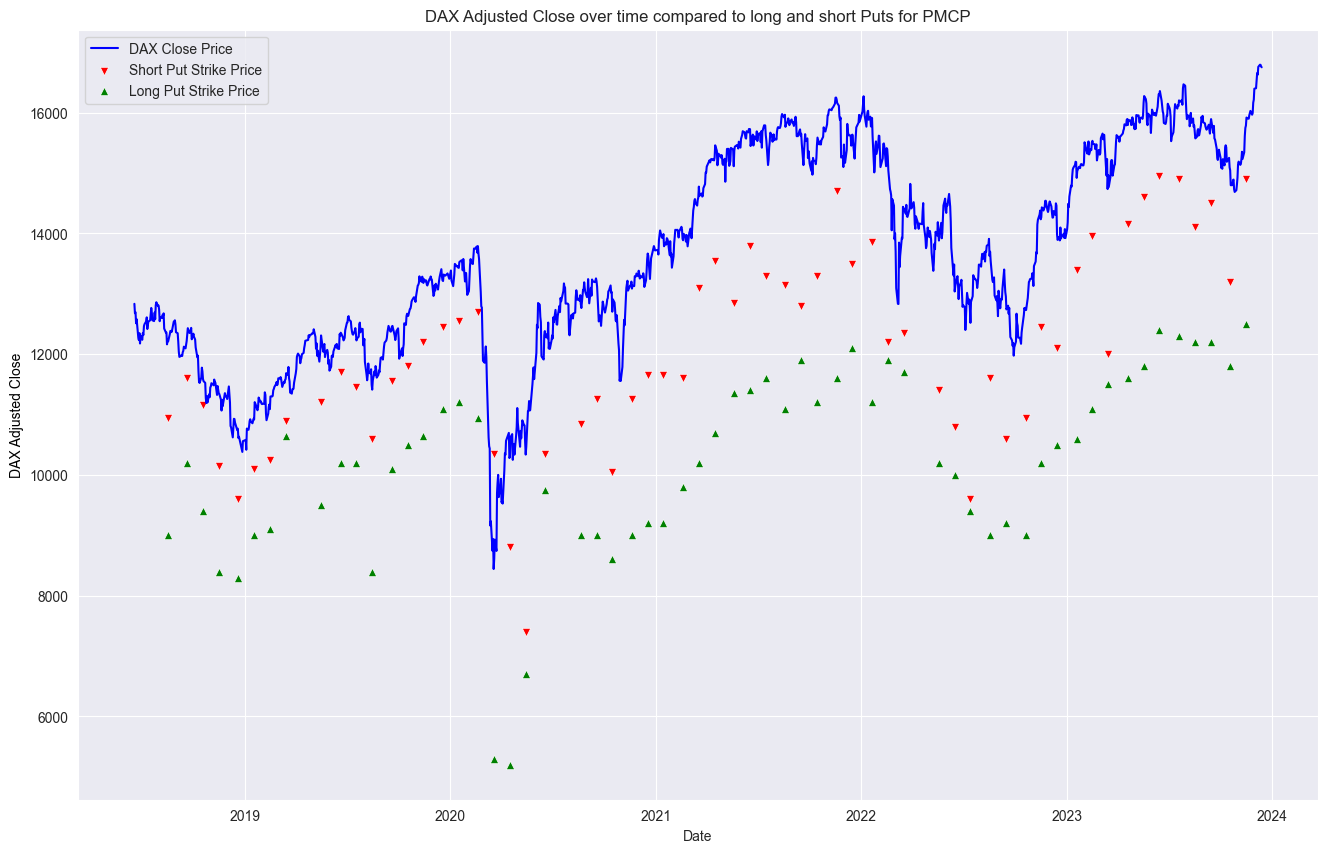

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.figure(figsize=(16, 10))
ax1 = plt.gca()
sns.lineplot(x=dax.Date, y=dax['Adj Close'], label='DAX Close Price', color='blue', ax=ax1)
sns.scatterplot(x=tmp[tmp.action == 'sell'].date, y=tmp[tmp.action == 'sell']['strike_price'], color='red', label='Short Put Strike Price', marker='v', ax=ax1)
sns.scatterplot(x=tmp[tmp.action == 'buy'].date, y=tmp[tmp.action == 'buy']['strike_price'], color='green', label='Long Put Strike Price', marker='^', ax=ax1)

ax1.set_title('DAX Adjusted Close over time compared to long and short Puts for PMCP')
ax1.set_ylabel('DAX Adjusted Close', color='black')
ax1.legend(loc='upper left')
plt.savefig('./figures/pmcp_result.pdf')

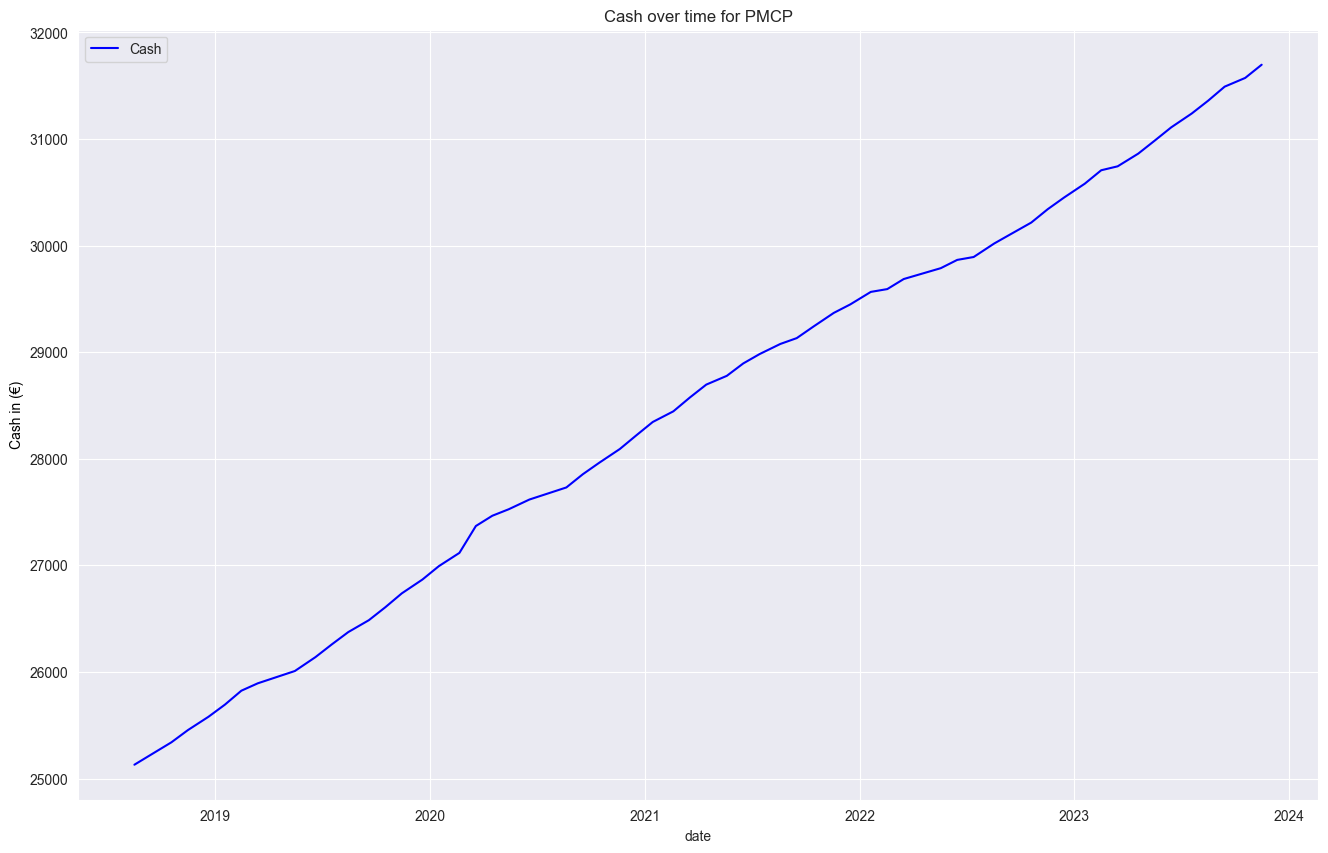

In [9]:
# plot strike price of action sell over time
cash_history = pd.DataFrame(state_put['cash_history'])

cash_history_last = cash_history.groupby(cash_history['date'].dt.date).apply(lambda x: x.iloc[-1]).reset_index(drop=True)
# Plotting
sns.set_style('darkgrid')
plt.figure(figsize=(16, 10))
ax1 = plt.gca()
sns.lineplot(x=cash_history_last['date'], y=cash_history_last['cash'], label='Cash', color='blue', ax=ax1)
ax1.set_title('Cash over time for PMCP')
ax1.set_ylabel('Cash in (€)', color='black')
ax1.legend(loc='upper left')
plt.savefig('./figures/pmcp_cash.pdf')


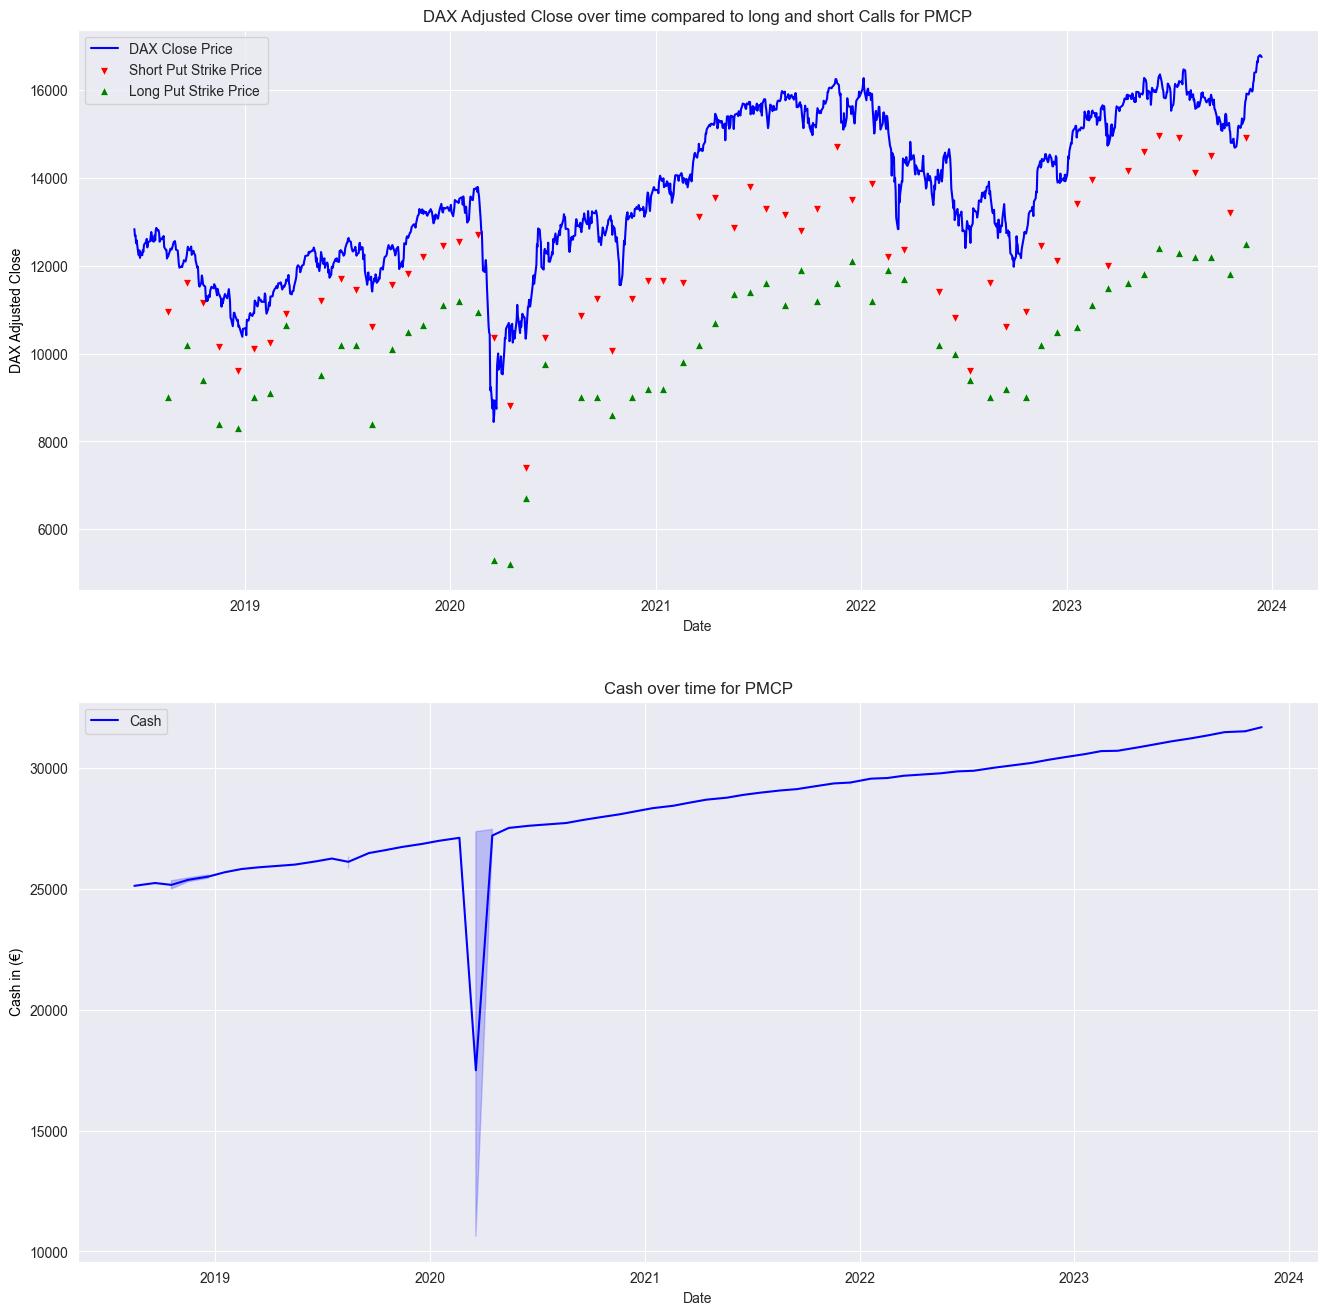

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

tmp = pd.DataFrame(state_put['transaction_history'])
cash_history = pd.DataFrame(state_put['cash_history'])

sns.set_style('darkgrid')
fig, axs = plt.subplots(2, 1, figsize=(16, 16))
sns.lineplot(x=dax.Date, y=dax['Adj Close'], label='DAX Close Price', color='blue', ax=axs[0])
sns.scatterplot(x=tmp[tmp.action == 'sell'].date, y=tmp[tmp.action == 'sell']['strike_price'], color='red', label='Short Put Strike Price', marker='v', ax=axs[0])
sns.scatterplot(x=tmp[tmp.action == 'buy'].date, y=tmp[tmp.action == 'buy']['strike_price'], color='green', label='Long Put Strike Price', marker='^', ax=axs[0])
#sns.lineplot(x=cash_history.date, y=cash_history.cash, label='Cash', color='black', ax=ax1)

axs[0].set_title('DAX Adjusted Close over time compared to long and short Calls for PMCP')
axs[0].set_ylabel('DAX Adjusted Close', color='black')
axs[0].set_xlabel('Date')
axs[0].legend(loc='upper left')

cash_history = pd.DataFrame(state_put['cash_history'])
cash_history_last = cash_history.groupby(cash_history['date'].dt.date).apply(lambda x: x.iloc[-1]).reset_index(drop=True)
sns.lineplot(x=cash_history['date'], y=cash_history['cash'], label='Cash', color='blue', ax=axs[1])
axs[1].set_title('Cash over time for PMCP')
axs[1].set_ylabel('Cash in (€)', color='black')
axs[1].set_xlabel('Date')
axs[1].legend(loc='upper left')
plt.savefig('./figures/pmcp_result_combined.pdf')

In [11]:
state_put['cash']

31696.78573734385